# Self‑Supervised Learning & Interactive Latent Space Visualization

This notebook demonstrates a self‑supervised workflow using a dataset of PNG images (organized by class). We:
- Load and split the data using stratification.
- Perform KMeans clustering on flattened images and evaluate with a confusion matrix.
- Train a simple convolutional autoencoder (with training/validation loss monitoring).
- Extract latent features and evaluate them using Logistic Regression and Random Forest.
- **Interactively explore the latent space:** Use the sliders below to choose which latent dimensions to plot in an Altair scatter plot.


In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import pandas as pd
import altair as alt
import ipywidgets as widgets
from IPython.display import display, clear_output
import seaborn as sns
from collections import Counter
from PIL import Image

# Set device (for simplicity, we'll use CPU)
device = torch.device("cpu")
print("Using device:", device)

/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/simple_ae/bin/../lib/libjpeg.9.dylib' (no such file)'If you don'

Using device: cpu


In [2]:
# Define transforms: resize images to 64x64 and convert to tensor.
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Set the data directory. Each subfolder should correspond to one class.
data_dir = "./data/dataset"  
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print("Found classes:", dataset.classes)

# Get all indices and labels.
all_indices = np.arange(len(dataset))
all_labels = np.array(dataset.targets)

# Stratified split: 80% for train+val, 20% for test.
trainval_idx, test_idx = train_test_split(all_indices, test_size=0.2, stratify=all_labels, random_state=42)
# Split train+val into 90% train and 10% validation.
train_idx, val_idx = train_test_split(trainval_idx, test_size=0.1, stratify=all_labels[trainval_idx], random_state=42)

print(f"Total images: {len(dataset)}")
print(f"Training images: {len(train_idx)}")
print(f"Validation images: {len(val_idx)}")
print(f"Test images: {len(test_idx)}")
print("Training label distribution:", Counter(all_labels[train_idx]))

# Create subsets and DataLoaders.
batch_size = 32
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Found classes: ['circles', 'hexagons', 'pentagons', 'quatrefoil', 'spikes', 'squares', 'triangles']
Total images: 2100
Training images: 1512
Validation images: 168
Test images: 420
Training label distribution: Counter({1: 216, 0: 216, 4: 216, 2: 216, 6: 216, 3: 216, 5: 216})


In [3]:
# Flatten every image in the full dataset and run KMeans clustering.
all_X = []
all_y = []
for img, label in dataset:
    all_X.append(img.view(-1).numpy())
    all_y.append(label)
all_X = np.array(all_X)
all_y = np.array(all_y)
print("Data shape (samples x features):", all_X.shape)

# Run KMeans clustering (without using labels).
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_X)

Data shape (samples x features): (2100, 12288)


KMeans Clustering Accuracy: 21.10%
KMeans Clustering F1 Score: 0.1997


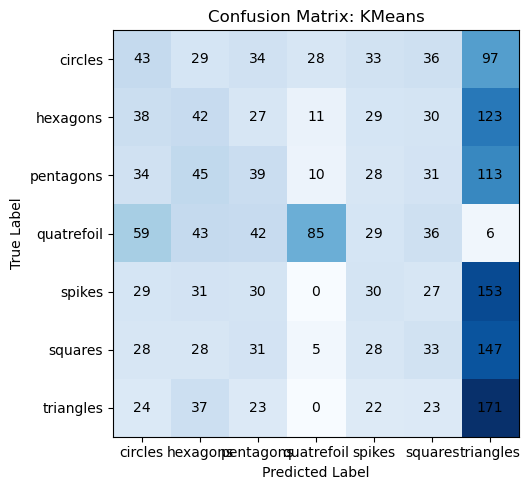

In [4]:
def map_cluster_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    new_preds = np.array([mapping[label] for label in y_pred])
    return new_preds, mapping

mapped_preds, mapping = map_cluster_labels(all_y, cluster_labels)

kmeans_acc = accuracy_score(all_y, mapped_preds) * 100
kmeans_f1 = f1_score(all_y, mapped_preds, average='macro')
print(f"KMeans Clustering Accuracy: {kmeans_acc:.2f}%")
print(f"KMeans Clustering F1 Score: {kmeans_f1:.4f}")

# Plot confusion matrix for KMeans.
cm_kmeans = confusion_matrix(all_y, mapped_preds)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm_kmeans, cmap="Blues")
ax.set_title("Confusion Matrix: KMeans")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticks(np.arange(len(dataset.classes)))
ax.set_yticks(np.arange(len(dataset.classes)))
ax.set_xticklabels(dataset.classes)
ax.set_yticklabels(dataset.classes)
for i in range(cm_kmeans.shape[0]):
    for j in range(cm_kmeans.shape[1]):
        ax.text(j, i, cm_kmeans[i, j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()


In [5]:
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        # Encoder: Convolutional layers to extract features.
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # -> (16,32,32)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> (32,16,16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # -> (64,8,8)
            nn.ReLU(),
            nn.Flatten()
        )
        # The output from the conv block is 64*8*8.
        self.fc_mu = nn.Linear(64 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(64 * 8 * 8, latent_dim)
        
        # Decoder: Map latent vector back to image space.
        self.decoder_fc = nn.Linear(latent_dim, 64 * 8 * 8)
        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (32,16,16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (16,32,32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (3,64,64)
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        h = self.encoder_conv(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        h_dec = self.decoder_fc(z)
        x_recon = self.decoder_conv(h_dec)
        return x_recon, mu, logvar
    
    def get_latent(self, x):
        h = self.encoder_conv(x)
        mu = self.fc_mu(h)
        return mu

# Instantiate the VAE.
vae = VAE(latent_dim=32).to(device)


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set a constant beta value for the KL divergence.
beta = 0.0000000001  # Adjust this value as needed.

vae_optimizer = optim.Adam(vae.parameters(), lr=1e-4)
# Use mean reduction for the reconstruction loss.
recon_criterion = nn.MSELoss(reduction='mean')
n_epochs = 150  # For demonstration; adjust as needed.
train_losses = []
val_losses = []

def kl_divergence(mu, logvar):
    # Compute the KL divergence for a batch (averaged over all elements).
    return -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

for epoch in range(n_epochs):
    vae.train()
    running_loss = 0.0
    # Use tqdm to display a progress bar over the training loader.
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")
    for imgs, _ in pbar:
        imgs = imgs.to(device)
        vae_optimizer.zero_grad()
        recon, mu, logvar = vae(imgs)
        recon_loss = recon_criterion(recon, imgs)
        kl_loss = kl_divergence(mu, logvar)
        loss = recon_loss + beta * kl_loss  # Use static beta.
        loss.backward()
        vae_optimizer.step()
        running_loss += loss.item() * imgs.size(0)  # Accumulate total loss.
        # Update progress bar with current metrics.
        pbar.set_postfix({
            "Beta": beta,
            "ReconLoss": f"{recon_loss.item():.4f}",
            "KL_Loss": f"{kl_loss.item():.4f}",
            "BatchLoss": f"{loss.item():.4f}"
        })
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    vae.eval()
    running_val = 0.0
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        recon, mu, logvar = vae(imgs)
        recon_loss = recon_criterion(recon, imgs)
        kl_loss = kl_divergence(mu, logvar)
        loss = recon_loss + beta * kl_loss
        running_val += loss.item() * imgs.size(0)
    val_loss = running_val / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

# Plot the training and validation loss curves.
plt.figure(figsize=(6,4))
epochs_range = np.arange(1, n_epochs+1)
plt.plot(epochs_range, train_losses, marker='o', label="Training Loss")
plt.plot(epochs_range, val_losses, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training & Validation Loss (Static Beta)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Extract latent features from the test set.
vae.eval()
all_latents = []
all_labels = []
for imgs, labels in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        latent = vae.get_latent(imgs)
    all_latents.append(latent.cpu().numpy())
    all_labels.extend(labels.numpy())
test_latents = np.concatenate(all_latents, axis=0)
test_labels = np.array(all_labels)
print("Extracted latent features shape:", test_latents.shape)

# Also extract file paths for the test images.
# 'test_dataset' is a Subset of the full dataset.
test_img_paths = []
for i in range(len(test_dataset)):
    idx = test_dataset.indices[i]  # get the corresponding index in the full dataset
    test_img_paths.append(dataset.imgs[idx][0])
print("Number of test image paths:", len(test_img_paths))

# Save latent features, labels, and file paths in a tuple for later use.
latent_data = (test_latents, test_labels, test_img_paths)

In [ ]:
# For demonstration, we use the test set for both training and evaluation.
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(test_latents, test_labels)
lr_preds = lr_clf.predict(test_latents)
lr_acc = accuracy_score(test_labels, lr_preds) * 100
lr_f1 = f1_score(test_labels, lr_preds, average='macro')

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(test_latents, test_labels)
rf_preds = rf_clf.predict(test_latents)
rf_acc = accuracy_score(test_labels, rf_preds) * 100
rf_f1 = f1_score(test_labels, rf_preds, average='macro')

print(f"Logistic Regression: Accuracy = {lr_acc:.2f}%, F1 Score = {lr_f1:.4f}")
print(f"Random Forest: Accuracy = {rf_acc:.2f}%, F1 Score = {rf_f1:.4f}")

# Plot confusion matrices.
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cm_lr = confusion_matrix(test_labels, lr_preds)
axs[0].imshow(cm_lr, cmap="Blues")
axs[0].set_title("Confusion Matrix: Logistic Regression")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")
axs[0].set_xticks(np.arange(len(np.unique(test_labels))))
axs[0].set_yticks(np.arange(len(np.unique(test_labels))))
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        axs[0].text(j, i, cm_lr[i,j], ha="center", va="center", color="black")

cm_rf = confusion_matrix(test_labels, rf_preds)
axs[1].imshow(cm_rf, cmap="Blues")
axs[1].set_title("Confusion Matrix: Random Forest")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")
axs[1].set_xticks(np.arange(len(np.unique(test_labels))))
axs[1].set_yticks(np.arange(len(np.unique(test_labels))))
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        axs[1].text(j, i, cm_rf[i,j], ha="center", va="center", color="black")
plt.tight_layout()
plt.show()

In [ ]:
# Cell: Reconstruct and Plot Images from Latent Space

import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

# Get a batch of test images.
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

vae.eval()
with torch.no_grad():
    # Get the latent representation (we use the mean from the encoder).
    latent = vae.get_latent(images)
    # Decode: Pass latent through the decoder.
    h_dec = vae.decoder_fc(latent)
    reconstructions = vae.decoder_conv(h_dec)

# Move images to CPU.
images = images.cpu()
reconstructions = reconstructions.cpu()

# Convert tensors to PIL images for visualization.
to_pil = ToPILImage()

n = min(8, images.size(0))  # number of images to display
fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
for i in range(n):
    axes[0, i].imshow(to_pil(images[i]))
    axes[0, i].axis('off')
    axes[0, i].set_title("Original", fontsize=10)
    
    axes[1, i].imshow(to_pil(reconstructions[i]))
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstruction", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Ensure latent_data is available.
test_latents, test_labels, test_img_paths = latent_data

# Create interactive widgets for selecting latent dimensions.
x_slider = widgets.IntSlider(value=0, min=0, max=test_latents.shape[1]-1, description='X Dim:')
y_slider = widgets.IntSlider(value=1, min=0, max=test_latents.shape[1]-1, description='Y Dim:')

# Create a dropdown widget to select a sample.
options = {}
for i, lbl in enumerate(test_labels):
    class_name = dataset.classes[lbl]
    options[f"Index {i} - {class_name}"] = i
sample_dropdown = widgets.Dropdown(options=options, description="Select sample:")

def update_visualization(x_index, y_index, sample_index):
    # Create a DataFrame for the scatter plot.
    df = pd.DataFrame({
        "x": test_latents[:, x_index],
        "y": test_latents[:, y_index],
        "label": test_labels.astype(str)
    })
    chart = alt.Chart(df).mark_circle(size=60).encode(
        x=alt.X("x", title=f"Latent Dimension {x_index}"),
        y=alt.Y("y", title=f"Latent Dimension {y_index}"),
        color=alt.Color("label:N", scale=alt.Scale(scheme="tableau10"), legend=alt.Legend(title="True Label")),
        tooltip=["x", "y", "label"]
    ).properties(
        width=500,
        height=400,
        title="Interactive Latent Space Visualization"
    )
    clear_output(wait=True)
    display(widgets.HBox([x_slider, y_slider, sample_dropdown]))
    display(chart)
    
    # Load and display the corresponding image.
    selected_path = test_img_paths[sample_index]
    try:
        img = Image.open(selected_path)
        print(f"Displaying image for sample index {sample_index}:")
        display(img)
    except Exception as e:
        print(f"Error loading image: {e}")

# Tie the widgets to the update function.
out = widgets.interactive_output(update_visualization, {'x_index': x_slider, 'y_index': y_slider, 'sample_index': sample_dropdown})
display(widgets.HBox([x_slider, y_slider, sample_dropdown]))
display(out)
